nmon [432.84050044 433.01219632 433.89185421 434.04436375 434.93658313
 435.06844774]


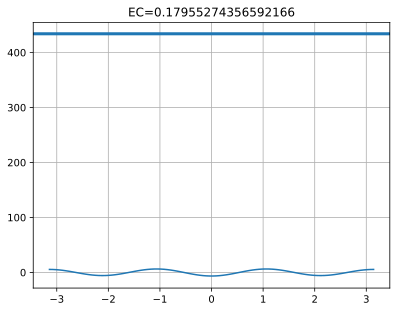

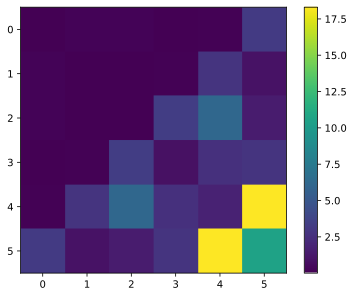

[2.227947298319748]


In [5]:
from nmon import *
N = 2
M = 3
EC_shunt = 0.18

nmon = Nmon(N=N, M=M, EJN=2.993684210526316, EJM=0.18, EC_shunt=EC_shunt)

nmon.hamiltonian_calc(flux=0.0, ng=[0.5, 0.5, 0.5, 0.5], num_levels=6, make_plot=True)

print(nmon.transition_freqs)


In [6]:
from nmon import *

EC_shunt = 0.18

N = 2
M = 3

N_EJN = 20
N_EJM = 20
N_flux = 5

flux_list = np.linspace(0, 0.5, N_flux)
EJM_list = np.linspace(1*EC_shunt, 100*EC_shunt, N_EJN)
EJN_list = np.linspace(1*EC_shunt, 100*EC_shunt, N_EJM)

relative_anharm_list = np.zeros((N_EJM , N_EJN, N_flux))
w01_list = np.zeros((N_EJM , N_EJN, N_flux))
w12_list = np.zeros((N_EJM , N_EJN, N_flux))
w01_variation_list = np.zeros_like(w01_list)

for i in tqdm(range(N_EJM)):
    for j in range(N_EJN):
        nmon = Nmon(N=N, M=M, EJM=EJM_list[i], EJN=EJN_list[j], EC_shunt=EC_shunt)
        for k, flux in enumerate(flux_list):

            w01_local = np.full(2, None)

            try:
                nmon.hamiltonian_calc(flux=flux, ng=[0.5, 0.5, 0.5, 0.5], num_levels=6)
            except Exception:
                continue

            relative_anharm_list[i, j, k] = nmon.relative_anharm
            w01_list[i, j, k] = nmon.transition_freqs[0]
            try:
                w12_list[i, j, k] = nmon.transition_freqs[1]
            except Exception as e:
                print(e)
                print(nmon.EC_shunt, nmon.EJN, nmon.EJM, flux, nmon.transition_freqs, nmon.bound_state_energies)
                print()



            w01_local[0] = nmon.transition_freqs[0]
            try:
                nmon.hamiltonian_calc(flux=flux, ng=[0, 0, 0, 0], num_levels=3)
            except Exception:
                continue
            w01_local[1] = nmon.transition_freqs[0]

            w01_variation_list[i, j, k] = (np.max(w01_local) - np.min(w01_local))/np.min(w01_local)

  0%|          | 0/20 [5:00:36<?, ?it/s]


KeyboardInterrupt: 

In [7]:
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJM_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJM_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJN_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJN_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_flux_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), flux_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_rel_anharm_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), relative_anharm_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_variation_list)


In [8]:

EJM_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_EJM_list.npy".format(N, M, round(EC_shunt, 2)))
EJN_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_EJN_list.npy".format(N, M, round(EC_shunt, 2)))
flux_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_flux_list.npy".format(N, M, round(EC_shunt, 2)))
relative_anharm_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_rel_anharm_list.npy".format(N, M, round(EC_shunt, 2)))
w01_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_list.npy".format(N, M, round(EC_shunt, 2)))
w01_variation_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list.npy".format(N, M, round(EC_shunt, 2)))

In [15]:
np.all(relative_anharm_list_flux[:,:,0] == 0)

True

ValueError: vmin, vcenter, and vmax must be in ascending order

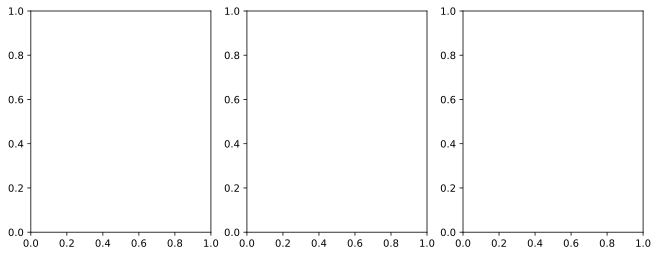

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

w01_variation_levels = [1e-1, 1e-2, 10**(-2.5)]

for w01_variation_lev in w01_variation_levels:

    for k, flux_value in enumerate(flux_list):

        EJN_grid, EJM_grid = np.meshgrid(EJN_list, EJM_list)

        # Extract arrays for the current flux value
        relative_anharm_list = relative_anharm_list_flux[:, :, k]
        w01_list = w01_list_flux[:, :, k]
        w01_variation_list = w01_variation_list_flux[:, :, k]

        # Replace NaN values in relative_anharm_list
        relative_anharm_list[np.isnan(relative_anharm_list)] = 1

        # Create DataFrame for all data points
        data = {
            'EJN': EJN_grid.flatten(),
            'EJM': EJM_grid.flatten(),
            'RelativeAnharmonicity': relative_anharm_list.flatten(),
            'w01': w01_list.flatten(),
            'w01Variation': w01_variation_list.flatten()
        }
        df = pd.DataFrame(data)

        # Filter rows where w01Variation < 10^(-1)
        filtered_df = df[df['w01Variation'] < w01_variation_lev]

        # Identify the top N_anharm points (lowest anharmonicity values)
        N_anharm = 100
        best_points = filtered_df.nsmallest(N_anharm, 'RelativeAnharmonicity')

        # Adjust alpha values for star-points
        best_anharm_values = best_points['RelativeAnharmonicity'].values
        alphas = np.ones(N_anharm)
        for i in range(1, N_anharm):
            if abs(best_anharm_values[i] - best_anharm_values[i - 1]) > 1e-3:
                alphas[i:] = np.logspace(0, -2, N_anharm - i)
                break

        # Plot with contourf and overlay star-points
        fig, axes = plt.subplots(1, 3, figsize=(11, 4))

        # First subplot: Relative Anharmonicity
        norm = colors.TwoSlopeNorm(vmin=df['RelativeAnharmonicity'].min(), vcenter=0, vmax=0.5)
        levels = np.concatenate((np.linspace(df['RelativeAnharmonicity'].min(), -1e-5, 50), 
                                np.linspace(0, 0.5, 50)))
        im1 = axes[0].contourf(EJN_grid / EC_shunt, EJM_grid / EC_shunt, 
                            relative_anharm_list, levels=levels, cmap='tab20c', norm=norm)
        fig.colorbar(im1, ax=axes[0], label='(w12 - w01) / w01')
        axes[0].set_title(r"$\delta w01 < {}$".format(round(w01_variation_lev, 3)))
        axes[0].set_xlabel('EJN / EC')
        axes[0].set_ylabel('EJM / EC')

        # Overlay star-points
        axes[0].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)

        # Second subplot: w01
        im2 = axes[1].contourf(EJN_grid / EC_shunt, EJM_grid / EC_shunt, 
                            w01_list, levels=100, cmap='viridis')
        fig.colorbar(im2, ax=axes[1], label='w01')
        axes[1].set_title(f"Transition Frequency w01\nFlux = {flux_value} Phi0")
        axes[1].set_xlabel('EJN / EC')
        axes[1].set_ylabel('EJM / EC')

        # Overlay star-points
        axes[1].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)

        # Third subplot: Log10 of w01 Variation
        im3 = axes[2].contourf(EJN_grid / EC_shunt, EJM_grid / EC_shunt, 
                            np.log10(w01_variation_list), levels=100, cmap='inferno')
        fig.colorbar(im3, ax=axes[2], label='log10((max(w01) - min(w01)) / min(w01))')
        axes[2].set_title(f"w01 Variation (Log Scale)\nEC={round(EC_shunt, 2)} GHz")
        axes[2].set_xlabel('EJN / EC')
        axes[2].set_ylabel('EJM / EC')

        # Overlay star-points
        axes[2].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)

        # Adjust layout and save the figure
        plt.tight_layout()
        plt.savefig(f"./data_figures/N={N}_M={M}_EC={round(EC_shunt, 2)}_flux_{k}_combined_plots.pdf")
        plt.show()
